In [3]:
import os
import numpy as np
import cv2
import gc
from tqdm import tqdm
import platform

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras._tf_keras.keras.applications import ResNet50
from keras._tf_keras.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.preprocessing.image import img_to_array

from transformers import ViTImageProcessor, TFViTModel, TFViTForImageClassification

import matplotlib.pyplot as plt
import seaborn as sns


/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Detect Apple Silicon and force CPU usage for TensorFlow if needed
if platform.machine() == "arm64" and platform.system() == "Darwin":
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    tf.config.set_visible_devices([], 'GPU')

# ------------------ CONFIG ------------------
IMAGE_SIZE = (224, 224)
DATASET_DIR = 'Data_disease'
TRAIN_DIR = os.path.join(DATASET_DIR, 'Train')
TEST_DIR = os.path.join(DATASET_DIR, 'Validation')

In [5]:

# ------------------ LOAD IMAGES ------------------
def load_dataset(directory, preprocess_func=None, class_map=None):
    X, y = [], []
    class_names = sorted(os.listdir(directory)) if class_map is None else sorted(class_map.keys())
    if class_map is None:
        class_map = {cls: idx for idx, cls in enumerate(class_names)}

    for cls in class_names:
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue
        for file in tqdm(os.listdir(cls_path), desc=f"Loading {cls}"):
            path = os.path.join(cls_path, file)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img_to_array(img)
            if preprocess_func:
                img = preprocess_func(img)
            else:
                img = img / 255.0
            X.append(img)
            y.append(class_map[cls])

    return np.array(X), np.array(y), class_map


In [6]:
import os

# Change the directory to the "Project" directory
os.chdir('/Users/rahiljain/UTD/Machine_Learning/Project')

# Verify the current working directory
print("Current working directory:", os.getcwd())


Current working directory: /Users/rahiljain/UTD/Machine_Learning/Project


In [7]:
# ------------------ LOAD DATA ------------------
print("Loading training data...")
X_train_full, y_train_full, class_map = load_dataset(TRAIN_DIR, preprocess_func=preprocess_resnet)
X_test_full, y_test_full, _ = load_dataset(TEST_DIR, preprocess_func=preprocess_resnet, class_map=class_map)

X_train_vit, _, _ = load_dataset(TRAIN_DIR, class_map=class_map)
X_test_vit, _, _ = load_dataset(TEST_DIR, class_map=class_map)

# One-hot encode for CNN training
y_train_cat = to_categorical(y_train_full, num_classes=len(class_map))
y_test_cat = to_categorical(y_test_full, num_classes=len(class_map))


Loading training data...


Loading Leaf Curl:  86%|████████▌ | 359/418 [00:00<00:00, 505.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  79%|███████▉  | 64/81 [00:00<00:00, 317.34it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  75%|███████▍  | 312/418 [00:00<00:00, 542.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  88%|████████▊ | 368/418 [00:00<00:00, 496.07it/

In [8]:
# ------------------ TRAIN CNN ------------------
from sklearn.utils import shuffle
X_train_full, y_train_cat = shuffle(X_train_full, y_train_cat, random_state=42)


print("Training CNN model...")
base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_cnn.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(len(class_map), activation='softmax')(x)

cnn_model = Model(inputs=base_cnn.input, outputs=out)

for layer in base_cnn.layers:
    layer.trainable = False

cnn_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_full, y_train_cat, validation_split=0.1, epochs=10, batch_size=32)

'''# Optional fine-tuning
for layer in base_cnn.layers:
    layer.trainable = True

cnn_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_full, y_train_cat, validation_split=0.1, epochs=5, batch_size=32)'''


Training CNN model...
Epoch 1/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 370s 846ms/step - accuracy: 0.5055 - loss: 2.0544 - val_accuracy: 0.8579 - val_loss: 0.5393
Epoch 2/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 369s 855ms/step - accuracy: 0.8317 - loss: 0.6192 - val_accuracy: 0.9179 - val_loss: 0.3400
Epoch 3/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 353s 817ms/step - accuracy: 0.8901 - loss: 0.3967 - val_accuracy: 0.9263 - val_loss: 0.2726
Epoch 4/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 356s 823ms/step - accuracy: 0.9202 - loss: 0.2971 - val_accuracy: 0.9316 - val_loss: 0.2366
Epoch 5/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 375s 869ms/step - accuracy: 0.9329 - loss: 0.2365 - val_accuracy: 0.9420 - val_loss: 0.2055
Epoch 6/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 352s 816ms/step - accuracy: 0.9491 - loss: 0.1819 - val_accuracy: 0.9472 - val_loss: 0.1925
Epoch 7/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 348s 806ms/step - accuracy: 0.9579 - loss: 0.1489 - val_accuracy: 0.9459 - val_loss: 0.1817
Epoch 8/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 364s 842ms/ste

"# Optional fine-tuning\nfor layer in base_cnn.layers:\n    layer.trainable = True\n\ncnn_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])\ncnn_model.fit(X_train_full, y_train_cat, validation_split=0.1, epochs=5, batch_size=32)"

In [9]:
# ------------------ EXTRACT CNN FEATURES ------------------
print("Extracting CNN features...")
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('global_average_pooling2d').output)
features_train_cnn = cnn_feature_extractor.predict(X_train_full, batch_size=32)
features_test_cnn = cnn_feature_extractor.predict(X_test_full, batch_size=32)

Extracting CNN features...
480/480 ━━━━━━━━━━━━━━━━━━━━ 344s 712ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 744ms/step


In [10]:
# ------------------ EXTRACT ViT FEATURES ------------------
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

def extract_vit_features(images, batch_size=16):
    features = []
    for i in tqdm(range(0, len(images), batch_size), desc="ViT Feature Extraction"):
        batch = images[i:i+batch_size].astype(np.float32)
        vit_inputs = vit_processor(images=list(batch), return_tensors="tf", do_rescale=False)
        outputs = vit_model(**vit_inputs)
        cls_features = outputs.last_hidden_state[:, 0, :]
        features.append(cls_features.numpy())
    return np.vstack(features)

features_train_vit = extract_vit_features(X_train_vit)
features_test_vit = extract_vit_features(X_test_vit)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
ViT Feature Extraction: 100%|██████████| 199/199 [07:16<00:00,  2.19s/it]


In [11]:
# ------------------ CONCATENATE FEATURES ------------------
print("Concatenating features...")
combined_train = np.concatenate([features_train_cnn, features_train_vit], axis=1)
combined_test = np.concatenate([features_test_cnn, features_test_vit], axis=1)
print("Concatenated features from CNN and ViT")


Concatenating features...
Concatenated features from CNN and ViT


In [ ]:

# ------------------ TRAIN SVM ------------------

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

pca = PCA(n_components=512)
X_train_pca = pca.fit_transform(combined_train)
X_test_pca = pca.transform(combined_test)

param_grid = {
    'svc__C': [1, 10, 100],
    'svc__gamma': ['scale', 0.01, 0.001],
    'svc__kernel': ['rbf', 'linear']
}
svm = GridSearchCV(make_pipeline(StandardScaler(), SVC()), param_grid, cv=3, n_jobs=-1)
svm.fit(X_train_pca, y_train_full)
print("Best parameters:", svm.best_params_)

'''print("Training SVM classifier...")
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale'))
svm.fit(combined_train, y_train_full)'''

/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


'print("Training SVM classifier...")\nsvm = make_pipeline(StandardScaler(), SVC(kernel=\'rbf\', C=10, gamma=\'scale\'))\nsvm.fit(combined_train, y_train_full)'

In [14]:
# ------------------ EVALUATE ------------------
print("Evaluating model...")
y_pred = svm.predict(X_test_pca)

print("\nClassification Report (CNN + ViT + SVM):")
print(classification_report(y_test_full, y_pred, target_names=class_map.keys()))
print(f"Accuracy: {accuracy_score(y_test_full, y_pred):.4f}")


Evaluating model...

Classification Report (CNN + ViT + SVM):
                             precision    recall  f1-score   support

American Bollworm on Cotton       0.25      0.20      0.22        30
      Anthracnose on Cotton       0.00      0.00      0.00        10
                  Army worm       0.89      0.21      0.33       351
 Bacterial Blight in cotton       0.42      0.76      0.54       284
   Becterial Blight in Rice       0.05      0.55      0.09        22
                  Brownspot       0.05      0.44      0.09         9
                Common_Rust       0.13      0.50      0.21        18
               Cotton Aphid       0.75      0.02      0.04       287
                  Flag Smut       0.64      0.58      0.61        24
             Gray_Leaf_Spot       0.17      0.35      0.23        20
              Healthy Maize       0.95      0.94      0.94       275
              Healthy Wheat       0.57      0.36      0.44        33
             Healthy cotton       0.84  

/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

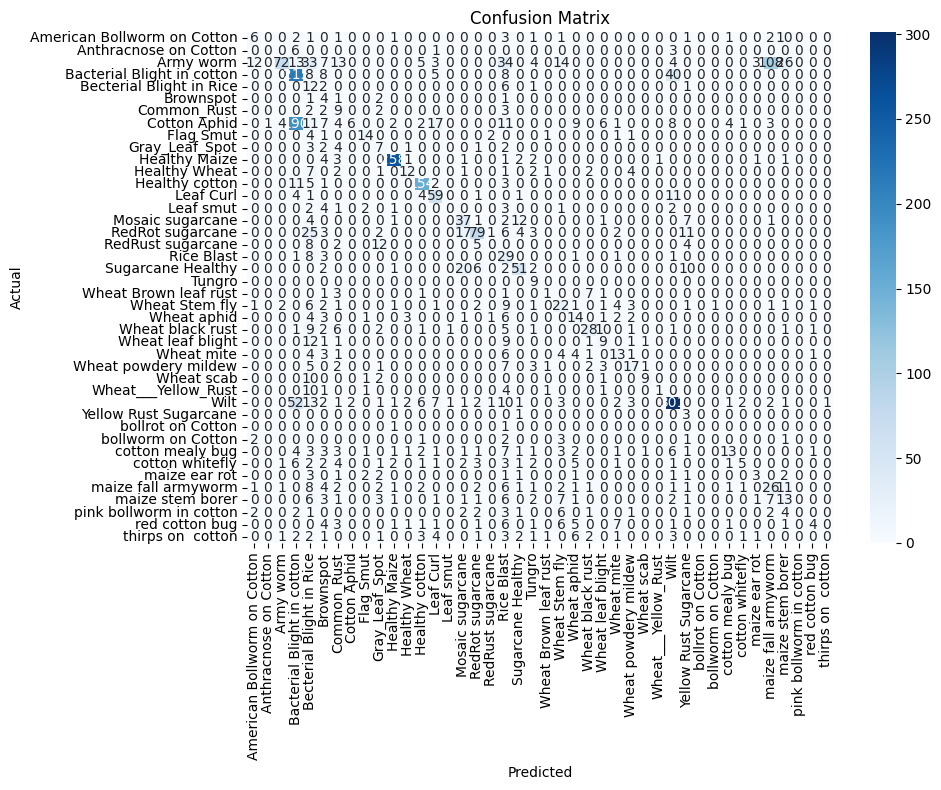

In [15]:
# ------------------ CONFUSION MATRIX ------------------
cm = confusion_matrix(y_test_full, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [13]:
import joblib

# Save SVM
joblib.dump(svm, 'Flask_svm_model.pkl')

# Save class_map
joblib.dump(class_map, 'Flask_class_map.pkl')
cnn_feature_extractor.save('Flask_cnn_feature_extractor.h5')
vit_model.save_pretrained('Flask_vit_model')
vit_processor.save_pretrained('Flask_vit_processor')


['Flask_vit_processor/preprocessor_config.json']